In [1]:
import numpy as np
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('chesterish')
import matplotlib.pyplot as plt

# Example of creating an R file with a flag for tolerance parameters
### This specific example contains JWST NIRSpec and MIRI data

[[ 1.0078603   0.01456451]
 [ 1.02242482  0.01473045]
 [ 1.03732121  0.0150615 ]
 ...
 [11.94970989  0.01779222]
 [11.96748066  0.01774931]
 [11.98520851  0.01772785]]


Text(0.5, 0, 'wl')

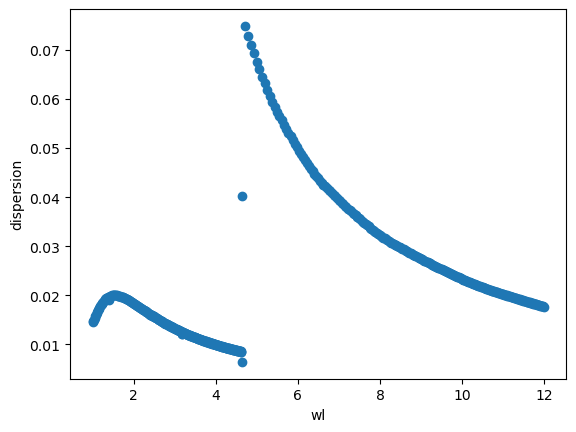

In [2]:
obs_data = np.loadtxt('../../SDSS1416_spectrum.txt')


wl =  obs_data[:, 0]  # lambda in microns


d_wl = np.zeros_like(wl)   #pixel width, dispersion
d_wl[1:-1] = (wl[2:] - wl[:-2]) / 2
d_wl[0] = wl[1] - wl[0]
d_wl[-1] = wl[-1] - wl[-2]

print(np.array([wl, d_wl]).T)

##### Slit limited parameters

slit_limited = 1.0  #1.0 yes, 0.0 no

resel_slit_lim = 2.0 # resolution element in case of slit limited, i.e. number of pixels per resolution



##### Source limited parameters

source_limited = 1.0 #1.0 yes, 0.0 no

D = 6.5e+6  #mirror size in micrometers

theta_pix = 0.11 #angular size of pixel



##### Both nirspec miri

nirspec_wl_range = [0.0, 4.63250113]  #the wavelength range of the nirspec data in micron

miri_wl_range = [4.63684082, 12.0] #the wavelength range of the miri data in micron

plt.scatter(wl,d_wl)
plt.ylabel('dispersion')
plt.xlabel('wl')

#plt.xlim(4.63,4.64)


In [3]:
def JWST_R(wl):
    
    '''Function that provides the Resolving Power (R) as a function of wavelength (wl) in micron,
       depending on jwst instrument

       Parameters:
       -wl: 1D array of wavelength


       Return:
       -R: 1D array of resolving powers
       -wl: 1D array of wavelength
       -log_f_param: 1D array of flags for tolerance parameter
       
       
       '''
    
    if slit_limited == 1.0 and source_limited == 0.0:
        
        R = wl/(d_wl * resel_slit_lim)
        
        log_f_param = np.ones_like(R)
        
        return R, wl, log_f_param
    
    
    elif source_limited == 1.0 and slit_limited == 0.0:
        
        theta_lambda = (648000/np.pi) * 1.028 * (wl/D) #FWHM in arcsec
        
        
        R = wl / (d_wl * (theta_lambda / theta_pix))
        
        log_f_param = np.ones_like(R)
        
        return R, wl, log_f_param
    
    
    elif source_limited == 1.0 and slit_limited == 1.0:
        
        ### nirspec
        
        nirspec_wl = wl[(wl >= nirspec_wl_range[0]) & (wl <= nirspec_wl_range[1])]
        
        nirspec_d_wl = d_wl[(wl >= nirspec_wl_range[0]) & (wl <= nirspec_wl_range[1])] 
        
        R_nirspec = nirspec_wl/(nirspec_d_wl * resel_slit_lim)
        
        log_f_param_nirspec = np.ones_like(R_nirspec)
        
        ### miri
        
        miri_wl = wl[(wl >= miri_wl_range[0]) & (wl <= miri_wl_range[1])]
        
        miri_d_wl = d_wl[(wl >= miri_wl_range[0]) & (wl <= miri_wl_range[1])]
        
        
        theta_lambda = (648000/np.pi) * 1.028 * (miri_wl/D)
        
        R_miri = miri_wl / (miri_d_wl * (theta_lambda / theta_pix))
        print(np.shape(R_miri),np.shape(R_nirspec))
        
        log_f_param_miri = np.full_like(R_miri, 2)
        
        #plt.plot(nirspec_wl,R_nirspec)
        #plt.plot(miri_wl,R_miri)
        
        return np.concatenate((R_nirspec, R_miri)), np.concatenate((nirspec_wl, miri_wl)), np.concatenate((log_f_param_nirspec, log_f_param_miri))
    
    else:
        
        print('Error: please check source_limited and slit_limited.')
        
           
        

In [4]:
R, wavelengths, log_f = JWST_R(wl)
print(np.array([R, wavelengths,log_f]).T)
print(np.mean(R))
print(np.max(R))
np.savetxt('SDSS_R.txt',np.array([R, wavelengths]).T )
np.savetxt('SDSS_R_logf.txt',np.array([R, wavelengths,log_f]).T )

(246,) (275,)
[[ 34.59986004   1.0078603    1.        ]
 [ 34.70445827   1.02242482   1.        ]
 [ 34.43619059   1.03732121   1.        ]
 ...
 [189.52108532  11.94970989   2.        ]
 [189.97932076  11.96748066   2.        ]
 [190.20927045  11.98520851   2.        ]]
132.82601843599036
359.88364511946656


In [5]:
print(np.shape(wl),np.shape(R))

(521,) (521,)


<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_666654/1843615152.py:2: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel(f"Wavelength [$\mu$m]")


Text(0, 0.5, 'Resolving Power')

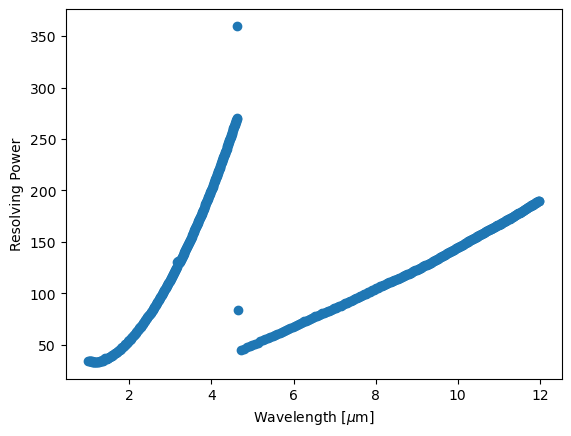

In [6]:
plt.scatter(wl, R)
plt.xlabel(f"Wavelength [$\mu$m]")
plt.ylabel('Resolving Power')




<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_666654/782047163.py:4: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel(f"Wavelength [$\mu$m]")


132.4826266209846 131.7388892173673 270.67395187852395


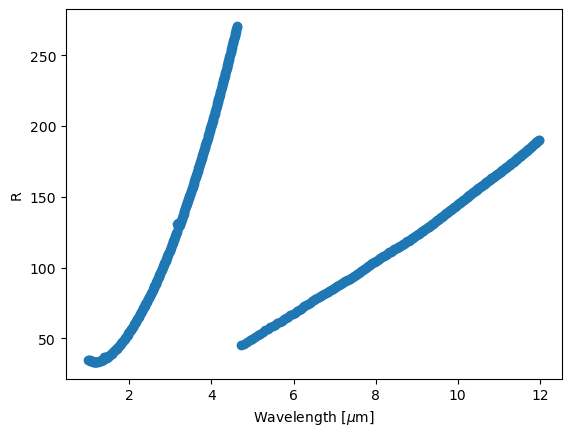

In [7]:
mask = (wl < 4.63) | (wl > 4.64)
wl_masked = wl[mask]
R_masked = R[mask]
plt.xlabel(f"Wavelength [$\mu$m]")
plt.ylabel("R")
plt.scatter(wl_masked, R_masked)
print(np.mean(R_masked), np.median(R_masked), np.max(R_masked))